### APRENDIZAJE PROFUNDO PARA PROCESAMIENTO DE INFORMACIÓN BIOMÉTRICA

# Práctica: Biometría Facial
### GRUPO 
* Hajar Boulehdid
* Sofía Santos Schmick
* Andrés Teruel Fernández

---


## Introducción
La biometría facial es un campo de la inteligencia artificial y el aprendizaje profundo con aplicaciones que van desde la verificación de identidad hasta la clasificación de atributos demográficos, como el género y la etnia. Sin embargo, la precisión y equidad de estos sistemas pueden verse afectadas por sesgos en los datos de entrenamiento.

El objetivo principal de este trabajo es estudiar cómo se trabajan con rasgos biométricos, realizar análisis sobre estos e implementar modelos para evaluar el impacto del sesgo en la clasificación de atributos faciales. En particular, se investigará cómo la composición étnica de los datos de entrenamiento influye en el rendimiento de los modelos de clasificación de género. Para ello, se explorará el uso de modelos preentrenados, como ResNet-50, para extraer características faciales (embeddings), que posteriormente serán utilizadas en la construcción de clasificadores de atributos demográficos. 

El primer paso es poner a punto el sistema para garantizar el correcto funcionamiento de la práctica. Para ello, es necesario crear un nuevo entorno con las siguientes versiones de librerías:
* Keras: 2.10.0
* Keras-Processing: 1.1.2
* TensorFlow: 2.10.1
* OpenCV: 4.10.0
* NumPy: 1.26.4

Una vez configurado el entorno con estas versiones, se procede a ejecutar el archivo `face_recognition_main.py`, en el cual se importan todas las librerías y funciones necesarias para el desarrollo de esta práctica.

In [1]:
import os
import numpy as np

# Remove most annoying tensorflow warnings
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

from face_recognition_main import *

---

## Carga de los datos

En esta sección utilizamos la función **load_datasets()** para la carga de dos conjuntos de datos que utilizaremos a lo largo de toda la práctica. Estos datasets estan formados por embeddigs de imágenes faciales procedentes de DiveFace.

Dichos datasets ya están preprocesados y guardados en dos archivos *pickle* para acelerar la ejecución del notebook.

In [2]:
embeddings_10_ppl_dataset, main_embeddings_dataset = load_datasets()

Embeddings dataset already exists. Loading...
Embeddings dataset already exists. Loading...
Embeddings datasets loaded.


---

## Tarea 1.0: Comparación de Imágenes para Verificación de Identidad
En esta tarea, vamos a comparar varias imágenes faciales para determinar si pertenecen o no a la misma identidad. El objetivo es revisar y entender el código proporcionado, y luego aplicarlo para comparar imágenes y verificar si corresponden a la misma persona.

In [3]:
def compare_images(img_path1, img_path2, threshold=0.5):
    """ Compara dos imágenes y devuelve si pertenecen a la misma persona """
    
    f1 = extract_features(img_path1, True)
    f2 = extract_features(img_path2, True)
    
    similarity = np.dot(f1, f2)
    
    if similarity >= threshold:
        print(f"Las imágenes pertenecen a la misma persona con similitud {similarity:.2f}")
        return True
    else:
        print(f"Las imágenes pertenecen a diferentes personas con similitud {similarity:.2f}")
        return False

In [4]:
"""Comparamos si son la misma persona a través de una simple.Detectamos las caras de las imagenes."""
images_dir = os.path.join('..', 'data', 'imagenes')
images = [os.path.join(images_dir, f"{i}.jpg") for i in range(4)]

for i in range(len(images)):
    for j in range(i + 1, len(images)):
        image1 = images[i]
        image2 = images[j]
        
        print(f"Image {i} vs image {j}: ", end='')
        compare_images(image1, image2)

Image 0 vs image 1: Las imágenes pertenecen a la misma persona con similitud 0.61
Image 0 vs image 2: Las imágenes pertenecen a diferentes personas con similitud 0.33
Image 0 vs image 3: Las imágenes pertenecen a diferentes personas con similitud 0.36
Image 1 vs image 2: Las imágenes pertenecen a diferentes personas con similitud 0.38
Image 1 vs image 3: Las imágenes pertenecen a diferentes personas con similitud 0.24
Image 2 vs image 3: Las imágenes pertenecen a diferentes personas con similitud 0.21


En el directorio data/imagenes/ tenemos las siguientes imágenes con sus respectivas identidades:

* **0.jpg**: Albert Einstein
* **1.jpg**: Albert Einstein
* **2.jpg**: Nikola Tesla
* **3.jpg**: Stephen Hawking

El primer paso en la comparación es extraer los vectores de características faciales (embeddings). Luego, se evalúa la similitud entre los embeddings de dos imágenes y, si esta supera un umbral predefinido (0.5 en este caso), se considera que ambas imágenes pertenecen a la misma persona.  

Para medir la similitud, se utiliza el producto punto entre los embeddings, una métrica que refleja el grado de alineación entre los vectores en el espacio. Dado que los embeddings representan características en un espacio de alta dimensión, vectores más cercanos corresponden a rostros más similares.


Teniendo esto en cuenta, podemos observar que, al comparar todas las imágenes entre sí, la extracción de características y el cálculo de similitudes funcionan correctamente. Esto se debe a que el sistema solo identifica que las imágenes **0.jpg y 1.jpg** corresponden a la **misma persona** (Albert Einstein), ya que la similitud entre sus embeddings supera el umbral de 0.5. Por otro lado, las comparaciones entre las demás imágenes (que corresponden a personas diferentes) no superan este umbral, lo que confirma que el sistema está funcionando como se esperaba.

---

## Tarea 1.1: Generación de una Base de Datos y cálculo de FAR y FRR
Para este experimento, se utilizó un conjunto de datos reducido generado específicamente para este estudio. El dataset está compuesto por un total de 10 individuos, cada uno representado mediante 5 embeddings. A partir de estos datos, se calcularon las curvas correspondientes a la Tasa de Aceptación Falsa (FAR) y a la Tasa de Rechazo Falsa (FRR).

Asimismo, se generaron histogramas para visualizar la distribución de las similitudes calculadas entre pares genuinos (mismo individuo) e impostores (individuos distintos). Finalmente, se construyó la curva ROC (Receiver Operating Characteristic) con el fin de evaluar de manera global el rendimiento del sistema de reconocimiento.


In [3]:
# Dados los embeddings, generar dos arrays con los scores obtenidos 
# y la etiqueta real.
scores, y_true = retrieve_scores_and_true_labels(embeddings_10_ppl_dataset)

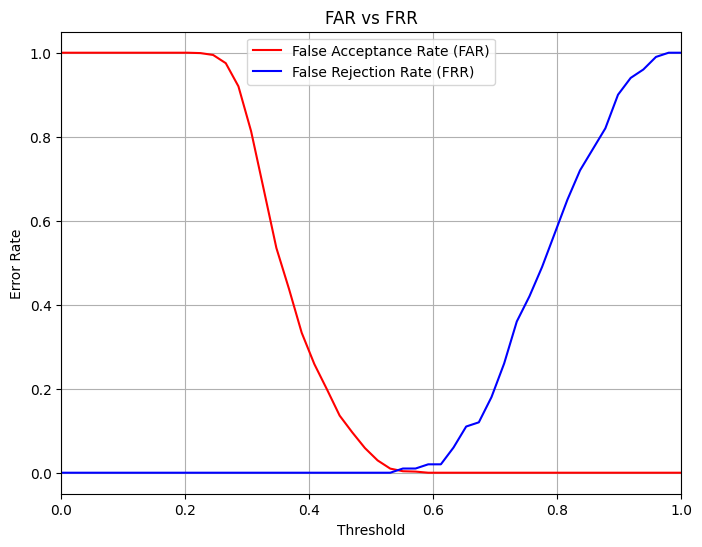

In [4]:
# Generar FAR, FRR y el gráfico
plot_far_frr_curves(scores, y_true)

Se conoce como **FAR (False Acceptance Rate)** al porcentaje de veces que el sistema identifica incorrectamente a dos personas diferentes como si fueran la misma. En otras palabras, representa la proporción de **falsos positivos**, donde el sistema acepta una identidad errónea. Por otro lado, el **FRR (False Rejection Rate)** es el porcentaje de veces que el sistema no reconoce correctamente a una persona como sí misma, es decir, la proporción de **falsos negativos**, donde el sistema rechaza una identidad que verdaderamente es correcta.

Al analizar las curvas de **FAR** y **FRR**, se observa que el área de intersección entre ambas es muy reducida y se encuentra en un intervalo limitado (0.5, 0.6). Esto es deseable en un modelo de reconocimiento biométrico, ya que permite establecer un umbral óptimo que minimice ambas tasas de error. Además, una intersección pequeña indica que, aunque sacrifiquemos alguna de las dos tasas en favor de la otra, el sacrificio no será demasiado grande. 

Los resultados obtenidos sugieren que el modelo es altamente competente en la comparación e identificación de personas. No obstante, es importante señalar que esta evaluación se ha realizado con un conjunto de datos limitado a solo 10 individuos, por lo que no es una comparativa suficientemente amplia para calificar el rendimiento del modelo de manera definitiva. Aun así, los resultados obtenidos son muy notables.

A continuación, vamos a analizar representamos gráficamente la distribución de estos valores de similitud.

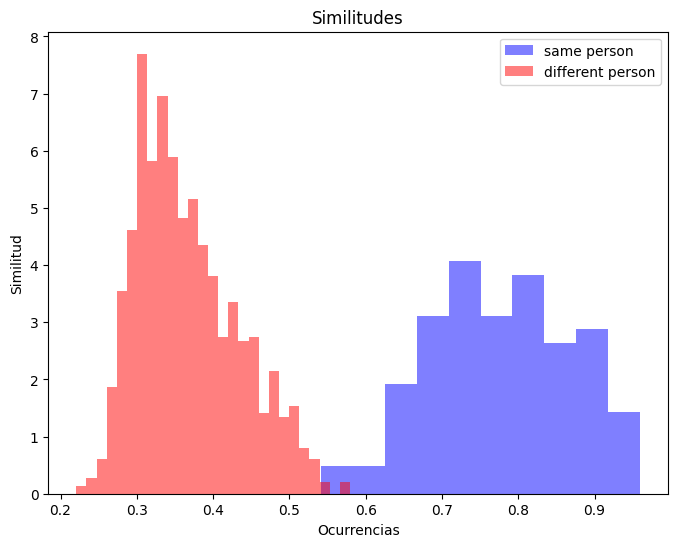

In [5]:
# Generar el histograma de similitudes
plot_similitude_histogram(scores, y_true)

Los histogramas de similitudes entre imágenes de una misma persona y de personas distintas confirman el intervalo para el umbral óptimo que se podía intuir a partir de las curvas FAR y FRR. Dicho intervalo se encuentra entre **0.53** y **0.58**. El solapamiento entre las distribuciones de similitudes es muy reducido, lo que indica al igual que las curvas FAR y FRR que, si se selecciona un umbral en uno de los extremos de dicho intervalo, no se producirán tasas elevadas de falsa aceptación ni de falso rechazo.

Los histogramas han sido normalizados con el objetivo de facilitar la comparación visual, ya que el número de comparaciones entre personas distintas es considerablemente mayor que entre imágenes de la misma persona. De no realizar esta normalización, la curva correspondiente a los impostores (en rojo) dominaría visualmente a la de los genuinos (en azul).

Al igual que con las curvas FAR y FRR, es importante ser cautelosos con la interpretación de los resultados, ya que el estudio se ha realizado con imágenes de solo 10 personas. Para evaluar el modelo de manera más rigurosa, sería necesario realizar un análisis con un conjunto de datos mucho más amplio.

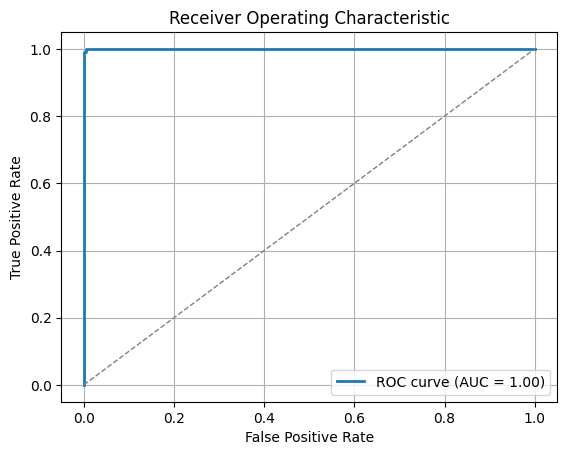

In [6]:
# Generar la curva ROC
plot_roc_curve(scores, y_true)


La curva **ROC (Receiver Operating Characteristic)** muestra la relación entre la tasa de verdaderos positivos (TPR) y la tasa de falsos positivos (FPR). Una buena curva ROC se aproxima lo máximo posible a la esquina superior izquierda del gráfico, lo que indica una alta sensibilidad y una baja tasa de falsos positivos.

En este caso, podemos observar que la curva es prácticamente perfecta en relación con lo que se busca. La línea asciende **muy verticalmente al inicio**, alcanzando una TPR ≈ 1 cuando la FPR ≈ 0. Luego, la curva se mantiene **horizontal hasta el final**, lo que indica que el modelo continúa clasificando correctamente a medida que se ajusta el umbral. El **área bajo la curva (AUC)** es de **1.00**, lo que representa una clasificación perfecta: el modelo separa completamente los pares genuinos de los impostores sin cometer errores.

Dado que estamos trabajando con un **dataset muy pequeño** (solo 10 personas con 5 embeddings cada una), este comportamiento es esperable si los embeddings están **bien separados** en el espacio de características. Probablemente, el modelo haya aprendido a distinguir correctamente a los individuos en este conjunto reducido. Sin embargo, un rendimiento tan elevado podría **no generalizarse** a conjuntos de datos más grandes o con mayor variabilidad. Por ello, aunque se trata de un excelente resultado preliminar, sería necesario validarlo utilizando un conjunto de datos más amplio y representativo.


---

## Tarea 1.2: Base de Datos DiveFace
A continuación, se va a leer la base de datos DiveFace y extraer los embeddings de 50 imágenes faciales (1 imagen por sujeto) de los 6 grupos demográficos (50 * 6 = 300 embeddings en total). La base de datos DiveFace contiene imágenes faciales de 3 grupos étnicos y 2 géneros, lo que resulta en 6 grupos demográficos.

In [17]:
# Llamar a la función para crear la base de datos de embeddings
embeddings_db_demographic = create_embeddings_subset(main_embeddings_dataset, 350)

# Verificar la cantidad de embeddings por grupo
for group_name, embeddings in embeddings_db_demographic.items():
    print(f"{group_name}: {len(embeddings)} embeddings")

MN4K_120: 350 embeddings
HN4K_120: 350 embeddings
MB4K_120: 350 embeddings
HB4K_120: 350 embeddings
HA4K_120: 350 embeddings
MA4K_120: 350 embeddings


Como observamos en la salida de la celda, hemos obtenido los embeddigs de 350 personas de los 6 grupos demográficos: Negros (Mujeres, Hombres), Blancos (Mujeres, Hombres), Asiáticos (Mujeres, Hombres).

---

## Tarea 1.3: t-SNE
En esta tarea se va a utilizar la técnica de reducción de dimensionalidad t-SNE para visualizar los embeddings extraídos en la Tarea 1.2 y analizar si es posible diferenciar los diferentes grupos demográficos.

El **t-SNE (t-Distributed Stochastic Neighbor Embedding)** es una técnica de reducción de dimensionalidad utilizada para visualizar datos de alta dimensión en un espacio de dos o tres dimensiones (en nuestro caso, dos). Su principal ventaja es que preserva las relaciones locales entre los puntos de datos, lo que la hace especialmente útil para identificar patrones y estructuras en los datos.


En nuestro caso, vamos a aplicar la técnica t-SNE para visualizar los embeddings de las caras para ver cómo se agrupan estos embeddings en función de dos criterios: primero por etnia , y luego por etnia y sexo. Esto nos permitirá analizar la distribución de los embeddings y evaluar posibles patrones en la representación de las caras.



In [9]:
def apply_tsne(embeddings_db):
    """Aplica t-SNE a los embeddings y los visualiza según su grupo étnico y género"""
    
    embeddings_list = []
    labels_list = []
    
    # 6 grupos según etnia y género
    group_mapping = {'HA': 0, 'MA': 1, 'HN': 2, 'MN': 3, 'HB': 4, 'MB': 5}  
    
    # Guardar los embeddings mappeados con su etiqueta
    for group_name, embeddings in embeddings_db.items():
        ethnic_group = group_name[:2]  # Primeras dos letras indican grupo
        label = group_mapping[ethnic_group]  # Obtener la etiqueta del grupo
        
        for emb in embeddings:
            if isinstance(emb, np.ndarray) and emb.shape[0] > 0:  
                embeddings_list.append(emb)
                labels_list.append(label)

    # Convertir la lista a una matriz numpy
    embeddings_matrix = np.vstack(embeddings_list)

    labels_array = np.array(labels_list)
 
    # Aplicar t-SNE
    tsne = TSNE(n_components=2, random_state=40)
    embeddings_2d = tsne.fit_transform(embeddings_matrix)
    
    return embeddings_2d, labels_array

In [10]:
# Aplicar t-SNE a los embeddings
embeddings, labels_array = apply_tsne(embeddings_db_demographic)

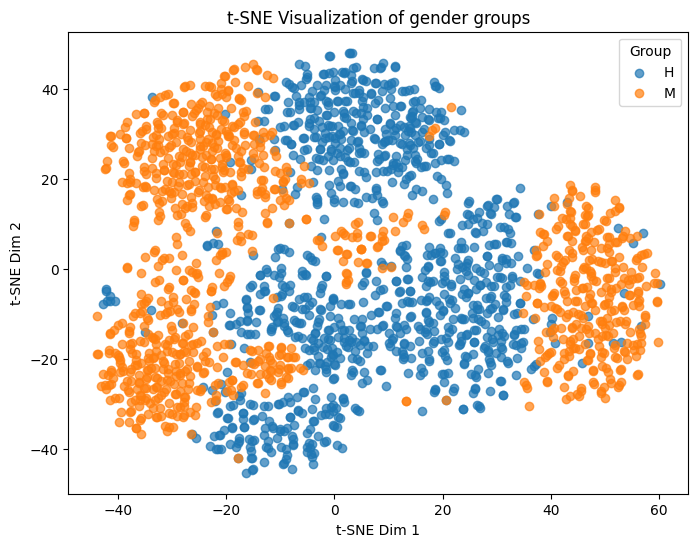

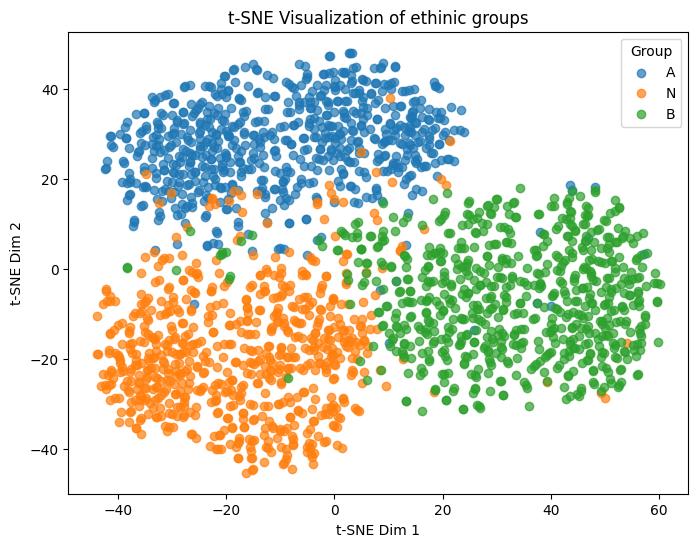

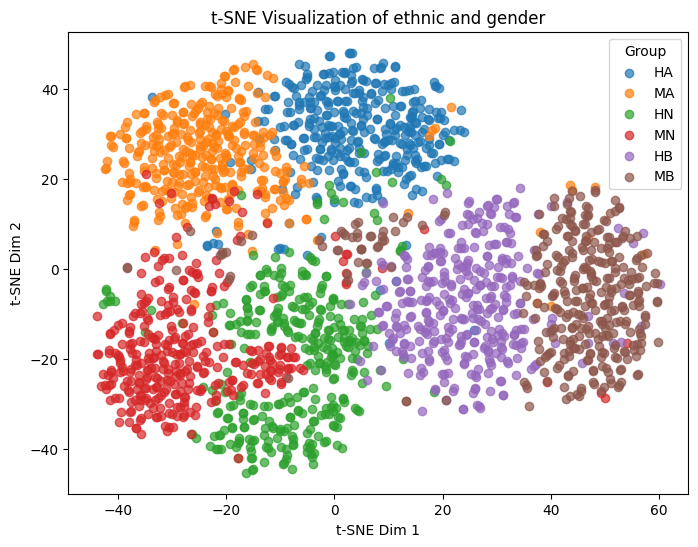

In [11]:
plot_tsne_with_gender(embeddings, labels_array)
plot_tsne_with_ethnic(embeddings, labels_array)
plot_tsne_complete(embeddings, labels_array)

Las siguientes visualizaciones muestran la representación de los embeddings obtenidos mediante el algoritmo t-SNE. 

En la **primera figura**, se representa la proyección t-SNE de los embeddings agrupados **por género**. Por lo general se observan dos grupos diferenciados, correspondientes a los géneros masculino (H) y femenino (M), lo cual sugiere que el modelo ha capturado diferencias significativas entre ambos sexos. A pesar de la clara separación global, se identifican zonas de proximidad entre ambos grupos, lo cual indica cierta superposición en los embeddings de algunos individuos. Un detalle llamativo es que, dentro de las agrupaciones de mujeres, aparecen varios embeddings de hombres dispersos, mientras que en las zonas dominadas por hombres apenas se observan puntos correspondientes a mujeres, y los pocos que existen tienden a ubicarse en los bordes de la agrupación azul. Este patrón puede reflejar una asimetría en la representación de género, donde las características del grupo masculino podrían estar mejor definidas o más concentradas, mientras que las del grupo femenino permiten cierta inclusión de perfiles masculinos, posiblemente debido a mayor variabilidad intra-clase.


En la **segunda figura**, la agrupación se realiza **en función de la etnia**. En este caso, se observan tres grandes grupos bien definidos, correspondientes a las tres categorías étnicas consideradas. Esta clara separación sugiere que el modelo ha logrado capturar características faciales distintivas de cada grupo. Sin embargo, también puede ser un indicio de un posible sesgo en la base de datos, ya que no se refleja una transición gradual entre etnias. En particular, se observan zonas de separación abrupta, donde sería esperable encontrar individuos mestizos o con rasgos intermedios, pero estos han sido eliminados durante el preprocesamiento, afectando negativamente la representación de la diversidad real.

Un aspecto relevante es que el grupo correspondiente a individuos asiáticos muestra muy poca o ninguna infiltración en las demás agrupaciones, lo que indica que el modelo ha aprendido representaciones especialmente distintivas para este grupo. El grupo blanco también presenta una buena delimitación, con escasa mezcla con otros. En cambio, el grupo negro es el que presenta mayor dispersión y se infiltra en mayor medida en las zonas correspondientes a otras etnias, lo que podría estar relacionado con una mayor variabilidad dentro del grupo. Esta asimetría en la distribución sugiere que el sistema podría tener dificultades adicionales para distinguir correctamente a los individuos de este grupo étnico en comparación con los otros.


La **tercera figura** muestra la representación de los embeddings considerando simultáneamente las **variables de género y etnia**. En esta visualización se identifican claramente seis agrupaciones diferenciadas, cada una correspondiente a una combinación específica de género y grupo étnico (por ejemplo, hombres asiáticos (HA), mujeres blancas (MB), etc.). La separación entre estos seis subgrupos es notable, lo que sugiere que el modelo integra de forma conjunta la información relacionada con ambos atributos en la generación de los embeddings.

No obstante, al aumentar el número de clases, también se observa un incremento en los errores de clasificación e infiltraciones entre grupos. Un ejemplo interesante se da dentro del grupo étnico blanco, donde se aprecia una mayor presencia de hombres dentro del grupo de mujeres, mientras que el fenómeno inverso, mujeres dentro del grupo de hombres, es mucho menos frecuente y, en caso de ocurrir, suele producirse en los bordes de la agrupación. Esta asimetría puede deberse a una mayor dispersión intra-clase en el grupo masculino.

El grupo asiático destaca por mostrar una clasificación más precisa entre hombres y mujeres, con una separación clara y escasa superposición entre ambos géneros. Esto sugiere que los rasgos faciales diferenciadores por género son más marcados o consistentes dentro de esta etnia. En contraste, el grupo negro es el que presenta mayor dispersión y solapamiento, indicando que el modelo tiene más dificultad para diferenciar género dentro de este grupo, posiblemente debido a una mayor variabilidad en los datos.


Cabe destacar que el algoritmo t-SNE introduce cierto grado de aleatoriedad en su ejecución, por lo que los resultados pueden variar levemente en diferentes ejecuciones. No obstante, la tendencia general de agrupamiento por atributos demográficos se mantiene constante.

---

## Tarea 2.1: Clasificadores de Genéro
En este apartado, entrenaremos tres modelos de clasificación de género, cada uno utilizando imágenes de un único grupo étnico.

* **Modelo A**: Entrenado exclusivamente con imágenes de personas de origen asiático.
* **Modelo B**: Entrenado exclusivamente con imágenes de personas de origen blanco.
* **Modelo N**: Entrenado exclusivamente con imágenes de personas de origen negro.

Cada modelo será entrenado con un total de 1000 imágenes, correspondientes a su respectivo grupo étnico, distribuidas equitativamente en 500 imágenes por género. Al igual que en los experimentos anteriores, los embeddings serán generados utilizando el modelo preentrenado ``resnet50.h5``.

En primer lugar, se divide cada conjunto de embeddings en dos subconjuntos: uno de entrenamiento (train) y otro de prueba (test), utilizando la función ``generate_test_train``.

In [18]:
embeddings_10_ppl_dataset, main_embeddings_dataset = load_datasets()
embeddings = divide_embeddings(main_embeddings_dataset)

for key, subset in embeddings.items():
    print(f"Ethnic group {key}:")
    for key2, values in subset.items():
        if "x_" in key2:
            if "train" in key2:
                print(f"\tTraining rows: {len(values)}")
            else: 
                print(f"\tTesting rows: {len(values)}")

Embeddings dataset already exists. Loading...
Embeddings dataset already exists. Loading...
Embeddings datasets loaded.
Ethnic group A:
	Training rows: 1005
	Testing rows: 495
Ethnic group B:
	Training rows: 1005
	Testing rows: 495
Ethnic group N:
	Training rows: 1005
	Testing rows: 495


En segundo lugar , creamos un modelo Clasificador de Género basado en embeddings que se define con la arquitectura de una red neuronal artificial simple. Este está compuesta por :
1. **Capa de entrada**. La red recibe un vector de 2048 dimensiones, que corresponde al embedding extraído previamente de la ResNet-50 preentrenada.
2. **Capa oculta**. Tiene 2048 neuronas y usa la función de activación ReLU.
3. **Capa de salida**. Es una capa de clasificación binaria con 2 neuronas, una para cada clase de género. Usa la activación softmax.

En cuanto a la compilación del modelo, se utiliza el optimizador Adam y la función de pérdida categorical_crossentropy, adecuada para tareas de clasificación multiclase.

A continuación, entrenamos un modelo para cada uno de los grupos étnicos: Asiáticos (Modelo A), Blancos (Modelo B), Negros (Modelo B).

In [19]:
gender_models = {'A': None, 'B': None, 'N': None}

for ethnicity in gender_models.keys():
    gender_models[ethnicity], accuracy, val_accuracy = train_gender_model(
        embeddings[ethnicity]["x_train"], 
        embeddings[ethnicity]["y_train"], 
        embeddings[ethnicity]["x_test"], 
        embeddings[ethnicity]["y_test"]) 
    
    print(f"Model {ethnicity} trained.")

Model A trained.
Model B trained.
Model N trained.


---

## Tarea 2.2: Evaluar Clasificadores de Género
Una vez entrenados los tres modelos en la tarea anterior, se procede a su evaluación cruzada utilizando imágenes de cada uno de los tres grupos étnicos.
La evaluación consiste en probar cada modelo con:

* Imágenes del mismo grupo étnico con el que fue entrenado.

* Imágenes de los otros dos grupos étnicos, con los que no tuvo contacto durante el entrenamiento.

Esto da lugar a un total de **9 combinaciones** de evaluación:
3 modelos × 3 conjuntos de prueba (uno por grupo étnico) =9 valores de accuracy.

Como métrica de rendimiento se utilizará la accuracy, que representa la proporción de predicciones correctas sobre el total de muestras evaluadas. 

In [21]:
get_all_accuracies_table(gender_models, embeddings)

,Model A,Model B,Model N
Dataset A,98.7879,86.6667,85.4545
Dataset B,83.8384,98.3838,83.2323
Dataset N,97.7778,91.9192,98.7879


En la tabla anterior se muestran los resultados obtenidos. Los resultados indican que cada modelo tiene un desempeño excelente cuando se evalúa con imágenes del mismo grupo étnico con el que fue entrenado (valores cercanos al 100%). Sin embargo, el rendimiento disminuye cuando los modelos se prueban con imágenes de otros grupos étnicos. 

Sin embargo, el rendimiento disminuye de forma considerable al ser evaluados con imágenes de otros grupos étnicos, lo que sugiere que los modelos podrían estar sobreajustándose a las características específicas de cada grupo étnico, lo que reduciría su capacidad de generalización a otras etnias. Esto pone en evidencia el sesgo empleado en los datos de entrenamiento. 

El Modelo A, entrenado con imágenes de personas asiáticas, alcanza una alta accuracy sobre el grupo negro (97.98%), pero desciende de forma más notable al evaluarse sobre el grupo blanco (83.64%). Esto sugiere que, si bien generaliza bien hacia un grupo étnico distinto, no lo hace de manera uniforme. Por el contrario, el Modelo B (blancos) y el Modelo N (negros) muestran un rendimiento más equilibrado entre los dos grupos externos, pero con valores ligeramente inferiores a los alcanzados por el Modelo A sobre el grupo negro. En conjunto, esto indica que ningún modelo presenta una generalización completamente robusta, y que la capacidad de adaptación a otros grupos étnicos depende de la combinación específica de origen y destino. Estos resultados demuestran que existen asimetrías y sesgos en la representación de los datos.

A continuación, se analizarán algunos ejemplos específicos con el objetivo de comprobar cómo responde el modelo ante casos concretos.

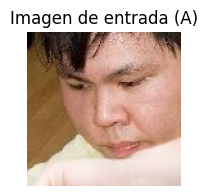


Usando el modelo 'A':
	Predicción mujer: 0.00003
	Predicción hombre: 0.99997
	Clase predicha: Hombre

Usando el modelo 'B':
	Predicción mujer: 0.02416
	Predicción hombre: 0.97584
	Clase predicha: Hombre

Usando el modelo 'N':
	Predicción mujer: 0.00068
	Predicción hombre: 0.99932
	Clase predicha: Hombre


In [22]:
predict_gender(gender_models, 'A', '../data/imagenes/2312469191_3.jpg', True)
predict_gender(gender_models, 'B', '../data/imagenes/2312469191_3.jpg', False)
predict_gender(gender_models, 'N', '../data/imagenes/2312469191_3.jpg', False)

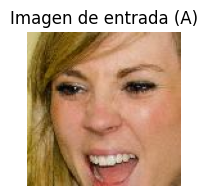


Usando el modelo 'A':
	Predicción mujer: 0.99928
	Predicción hombre: 0.00072
	Clase predicha: Mujer

Usando el modelo 'B':
	Predicción mujer: 1.00000
	Predicción hombre: 0.00000
	Clase predicha: Mujer

Usando el modelo 'N':
	Predicción mujer: 0.99278
	Predicción hombre: 0.00722
	Clase predicha: Mujer


In [23]:
predict_gender(gender_models, 'A', '../data/imagenes/5275910717_0.jpg', True)
predict_gender(gender_models, 'B', '../data/imagenes/5275910717_0.jpg', False)
predict_gender(gender_models, 'N', '../data/imagenes/5275910717_0.jpg', False)

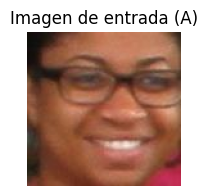


Usando el modelo 'A':
	Predicción mujer: 0.99986
	Predicción hombre: 0.00014
	Clase predicha: Mujer

Usando el modelo 'B':
	Predicción mujer: 0.99511
	Predicción hombre: 0.00489
	Clase predicha: Mujer

Usando el modelo 'N':
	Predicción mujer: 0.99985
	Predicción hombre: 0.00015
	Clase predicha: Mujer


In [24]:
predict_gender(gender_models, 'A', '../data/imagenes/7186948655_24.jpg', True)
predict_gender(gender_models, 'B', '../data/imagenes/7186948655_24.jpg', False)
predict_gender(gender_models, 'N', '../data/imagenes/7186948655_24.jpg', False)

Al probar con un **hombre asiático**, se observa que todos los modelos identifican correctamente el género. El modelo entrenado con imágenes de personas asiáticas alcanza una precisión de 0.999, mientras que el modelo de personas negras también obtiene un valor cercano (0.99) y el modelo entrenado con imágenes de personas blancas presenta un rendimiento ligeramente inferior, con una precisión del 0.97. 

En el caso de una **mujer caucásica**, la predicción es perfecta (1.00) con el modelo entrenado con datos de personas blancas, mientras que los otros modelos también obtienen resultados muy altos, sin bajar del 98% de precisión.

Por último, al evaluar una **mujer negra**, todos los modelos alcanzan una accuracy del 0.99, siendo el modelo entrenado con datos del mismo grupo étnico el que obtiene el mejor resultado. 

Al probar con un **hombre asiático**, se observa que todos los modelos identifican correctamente el género, aunque para el modelo entrenado con imágenes de asiáticos la precisión es de 0.999, mientras que los otros dos alcanzan aproximadamente un 0.98.

En general, se observa que el sistema ofrece un rendimiento muy sólido tanto en hombres como en mujeres, lo cual es coherente con el hecho de haber utilizado un **conjunto de datos equilibrado por género** durante el entrenamiento.


---

## Tarea 2.3: Clasificador de Genéro

De manera análoga al apartado anterior, se entrena un modelo clasificador de género, pero en este caso utilizando imágenes de los **tres grupos étnicos** de forma conjunta. Para ello, se emplean 1000 embeddings de cada grupo étnico, con un total de 3000 muestras, equilibradas en cuanto a género (500 por género y etnia).

En primer lugar, se divide cada conjunto de embeddings en subconjuntos de entrenamiento (train) y prueba (test) utilizando la función ``generate_test_train``. A continuación, se procede al entrenamiento del modelo, utilizando la misma arquitectura y configuración descritas en tareas previas.

In [25]:
x_train, x_test, y_train, y_test = generate_test_train(main_embeddings_dataset)

In [26]:
# Verificar los tamaños de los conjuntos
print(f"Tamaño del conjunto de entrenamiento (x_train): {len(x_train)}")
print(f"Tamaño del conjunto de prueba (x_test): {len(x_test)}\n")

# Verificar la distribución de clases en y_train (etiquetas)
unique_train, counts_train = np.unique(np.argmax(y_train, axis=1), return_counts=True)
print(f"Distribución de clases en el conjunto de entrenamiento:")
for u, c in zip(unique_train, counts_train):
    print(f"\tClase {u}: {c} ejemplos")

# Verificar la distribución de clases en y_test (etiquetas)
unique_test, counts_test = np.unique(np.argmax(y_test, axis=1), return_counts=True)
print(f"Distribución de clases en el conjunto de prueba:")
for u, c in zip(unique_test, counts_test):
    print(f"\tClase {u}: {c} ejemplos")

Tamaño del conjunto de entrenamiento (x_train): 3015
Tamaño del conjunto de prueba (x_test): 1485

Distribución de clases en el conjunto de entrenamiento:
	Clase 0: 1508 ejemplos
	Clase 1: 1507 ejemplos
Distribución de clases en el conjunto de prueba:
	Clase 0: 742 ejemplos
	Clase 1: 743 ejemplos


In [27]:
generic_model, accuracy, val_accuracy = train_gender_model(x_train, y_train, x_test, y_test) 
print(f"Generic model trained.")

Generic model trained.


---

## Tarea 2.4: Evaluar todos los Clasificadores de Género
A continuación, se evalúa el modelo de clasificación de género entrenado previamente utilizando imágenes de cada uno de los tres grupos étnicos por separado. El objetivo es analizar su rendimiento de forma desglosada y comprobar si el modelo responde de manera equitativa ante diferentes orígenes étnicos.

Esta evaluación consiste en probar el modelo con tres conjuntos de prueba, uno por grupo étnico, lo que da lugar a un total de **tres valores de precisión** (accuracy). Esta configuración permite observar si el entrenamiento conjunto ha logrado mejorar la generalización del modelo frente a la segmentación por etnia observada en los experimentos anteriores.

In [28]:
gender_models['generic'] = generic_model
get_all_accuracies_table(gender_models, embeddings)

,Model A,Model B,Model N,Model generic
Dataset A,98.7879,86.6667,85.4545,99.7980
Dataset B,83.8384,98.3838,83.2323,99.7980
Dataset N,97.7778,91.9192,98.7879,99.7980


Los resultados presentados en la tabla muestran un claro contraste entre los modelos entrenados de forma específica por etnia (Modelos A, B y N) y el modelo genérico entrenado con imágenes de los tres grupos étnicos. Mientras que los modelos específicos obtienen resultados muy altos únicamente cuando se evalúan con datos de su mismo grupo étnico, mostrando caídas notables al ser evaluados con imágenes de otros grupos, el modelo genérico mantiene una accuracy constante de 99.798% en los tres conjuntos de prueba, independientemente de la etnia. Esto evidencia una **mejor capacidad de generalización** del modelo genérico, gracias a haber sido entrenado con un conjunto de datos más diverso. A diferencia de los modelos individuales, que tienden a sobreajustarse a las características particulares de su grupo de entrenamiento, el modelo genérico logra abstraer mejor las diferencias demográficas y representar de manera más robusta los rasgos relevantes para la clasificación de género. Este resultado pone de manifiesto la importancia de emplear datasets variados y balanceados para evitar sesgos y mejorar la equidad del sistema.


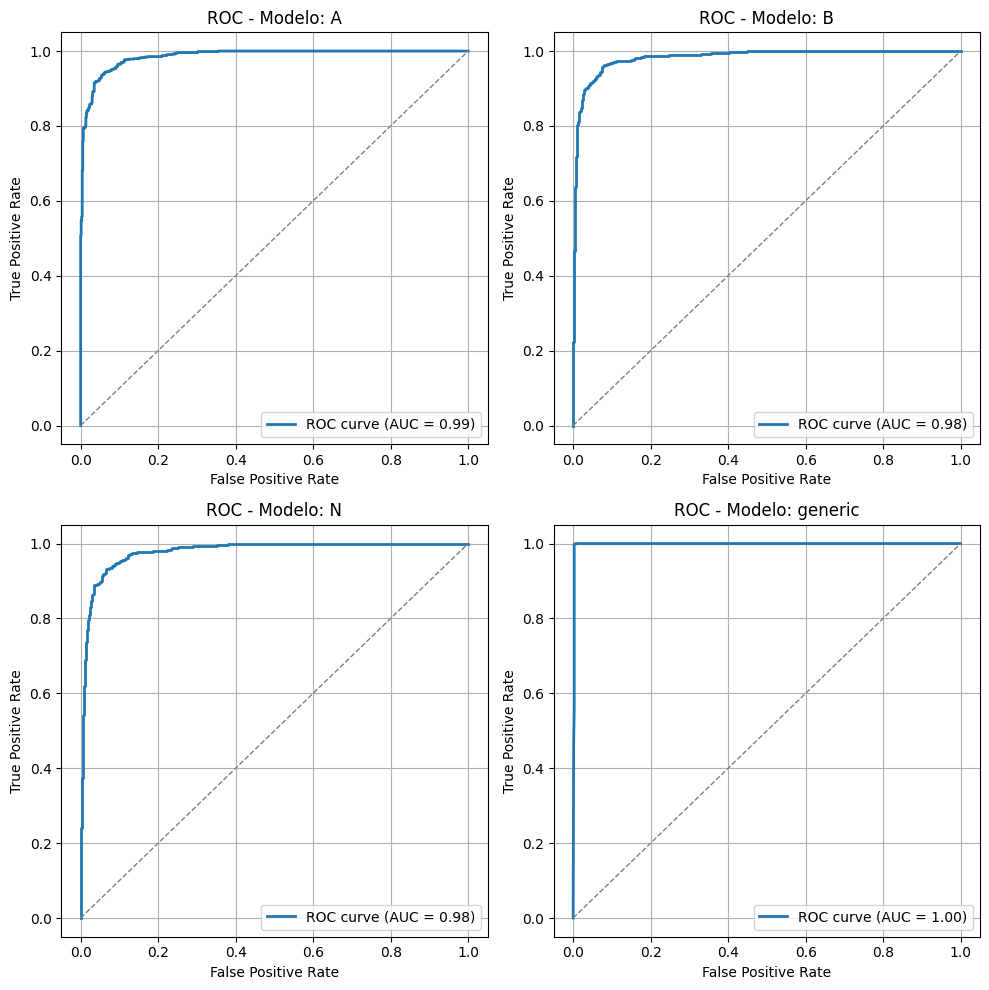

In [29]:
# Generar la curva ROC
get_all_roc_curves(gender_models, embeddings)

## Tarea 2.5 : Clasificador de Género y de Étnia

In [30]:
x_train, x_test, y_train, y_test = generate_test_train2(main_embeddings_dataset)

In [31]:
# Verificar los tamaños de los conjuntos
print(f"Tamaño del conjunto de entrenamiento (x_train): {len(x_train)}")
print(f"Tamaño del conjunto de prueba (x_test): {len(x_test)}\n")

# Verificar la distribución de clases en y_train (etiquetas)
unique_train, counts_train = np.unique(np.argmax(y_train, axis=1), return_counts=True)
print(f"Distribución de clases en el conjunto de entrenamiento:")
for u, c in zip(unique_train, counts_train):
    print(f"\tClase {u}: {c} ejemplos")

# Verificar la distribución de clases en y_test (etiquetas)
unique_test, counts_test = np.unique(np.argmax(y_test, axis=1), return_counts=True)
print(f"Distribución de clases en el conjunto de prueba:")
for u, c in zip(unique_test, counts_test):
    print(f"\tClase {u}: {c} ejemplos")

Tamaño del conjunto de entrenamiento (x_train): 3015
Tamaño del conjunto de prueba (x_test): 1485

Distribución de clases en el conjunto de entrenamiento:
	Clase 0: 503 ejemplos
	Clase 1: 502 ejemplos
	Clase 2: 502 ejemplos
	Clase 3: 502 ejemplos
	Clase 4: 503 ejemplos
	Clase 5: 503 ejemplos
Distribución de clases en el conjunto de prueba:
	Clase 0: 247 ejemplos
	Clase 1: 248 ejemplos
	Clase 2: 248 ejemplos
	Clase 3: 248 ejemplos
	Clase 4: 247 ejemplos
	Clase 5: 247 ejemplos


In [32]:
combined_model, accuracy, val_accuracy = train_combined_model(x_train, y_train, x_test, y_test)
print(f"Combined model trained.")

Combined model trained.


In [33]:
# Evaluar el modelo en el conjunto de test
test_loss, test_accuracy = combined_model.evaluate(x_test, y_test, verbose=0)

print(f"Accuracy en los datos de prueba: {test_accuracy * 100:.2f}%")

Accuracy en los datos de prueba: 97.31%


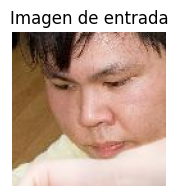


Usando el modelo combinado:
	Predicción para las clases (Género + Etnia):
	Predicción (HA): 0.99996
	Predicción (MA): 0.00004
	Predicción (HB): 0.00000
	Predicción (MB): 0.00000
	Predicción (HN): 0.00000
	Predicción (MN): 0.00000
	Clase predicha: Hombre Etnia A


In [34]:
predict_gender_ethnicity(gender_models, combined_model, '../data/imagenes/2312469191_3.jpg')

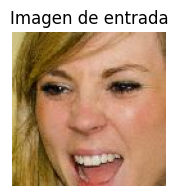


Usando el modelo combinado:
	Predicción para las clases (Género + Etnia):
	Predicción (HA): 0.00000
	Predicción (MA): 0.00000
	Predicción (HB): 0.00000
	Predicción (MB): 1.00000
	Predicción (HN): 0.00000
	Predicción (MN): 0.00000
	Clase predicha: Mujer Etnia B


In [35]:
predict_gender_ethnicity(gender_models, combined_model, '../data/imagenes/5275910717_0.jpg')

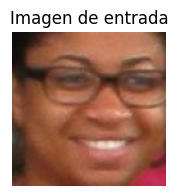


Usando el modelo combinado:
	Predicción para las clases (Género + Etnia):
	Predicción (HA): 0.00000
	Predicción (MA): 0.00000
	Predicción (HB): 0.00000
	Predicción (MB): 0.00000
	Predicción (HN): 0.00001
	Predicción (MN): 0.99999
	Clase predicha: Mujer Etnia N


In [36]:
predict_gender_ethnicity(gender_models, combined_model, '../data/imagenes/7186948655_24.jpg')

In [37]:
# Nota: podrias cambiar estas imagenes por variar

--- 
## Tarea 2.6 (extra) : Clasificador de Género genérico con Base de Datos sesgada

Se va a emplear un modelo genérico entrenado con los tres grupos étnicos, pero no de manera equitativa sino con una base de datos sesgada en la que habrá más individuos de una étnia que de otras. Esto refleja un escenario real, muchas veces se entrena bases de datos con una distribución desigual de datos, lo que puede llevar a sesgos en el modelo. En este caso, la predominancia de una etnia sobre las otras puede influir en el desempeño del modelo, haciendo que tenga mayor precisión para el grupo mayoritario y menor precisión para los grupos con menor representación.


**Biased Model 1 : 60%, 30%, 10%**

En el entrenamiento de este modelo, como en el de `generic_model`, se va a emplear un total de 3000 embeddings. Con el objetivo de estudiar el efecto que tiene una base de datos sesgada en las predicciones, vamos a entrenar un modelo con un 60% de embeddings pertenecientes a la etnia blanca (1800), un 30% pertenecientes a la etnia asiática (900) y un 10% perteneciente a la etnia negra (300). Cabe destacar que se va a tomar el mismo número de embeddings del género masculino que del femenino. 

In [38]:
_, bias_embedings_dataset = load_datasets()

bias_embedings_dataset['HN4K_120'] = bias_embedings_dataset['HN4K_120'][:5]
bias_embedings_dataset['MN4K_120'] = bias_embedings_dataset['MN4K_120'][:5]

bias_embedings_dataset['HA4K_120'] = bias_embedings_dataset['HA4K_120'][:250]
bias_embedings_dataset['MA4K_120'] = bias_embedings_dataset['MA4K_120'][:250] 

bias_embedings_dataset['HB4K_120'] = bias_embedings_dataset['HB4K_120'][:250]
bias_embedings_dataset['MB4K_120'] = bias_embedings_dataset['MB4K_120'][:250]

x_train, x_test, y_train, y_test = generate_test_train(bias_embedings_dataset)

# Verificar los tamaños de los conjuntos
print(f"\nTamaño del conjunto de entrenamiento (x_train): {len(x_train)}")
print(f"Tamaño del conjunto de prueba (x_test): {len(x_test)}\n")

# Verificar la distribución de clases en y_train (etiquetas)
unique_train, counts_train = np.unique(np.argmax(y_train, axis=1), return_counts=True)
print(f"Distribución de clases en el conjunto de entrenamiento:")
for u, c in zip(unique_train, counts_train):
    print(f"\tClase {u}: {c} ejemplos")

# Verificar la distribución de clases en y_test (etiquetas)
unique_test, counts_test = np.unique(np.argmax(y_test, axis=1), return_counts=True)
print(f"Distribución de clases en el conjunto de prueba:")
for u, c in zip(unique_test, counts_test):
    print(f"\tClase {u}: {c} ejemplos")

Embeddings dataset already exists. Loading...
Embeddings dataset already exists. Loading...
Embeddings datasets loaded.

Tamaño del conjunto de entrenamiento (x_train): 676
Tamaño del conjunto de prueba (x_test): 334

Distribución de clases en el conjunto de entrenamiento:
	Clase 0: 338 ejemplos
	Clase 1: 338 ejemplos
Distribución de clases en el conjunto de prueba:
	Clase 0: 167 ejemplos
	Clase 1: 167 ejemplos


In [39]:
generic_biased_model, accuracy, val_accuracy = train_gender_model(x_train, y_train, x_test, y_test) 
print(f"Generic biased model trained.")

Generic biased model trained.


In [40]:
gender_models['gen_bias1'] = generic_biased_model
get_all_accuracies_table(gender_models, embeddings)

,Model A,Model B,Model N,Model generic,Model gen_bias1
Dataset A,98.7879,86.6667,85.4545,99.7980,98.7879
Dataset B,83.8384,98.3838,83.2323,99.7980,98.1818
Dataset N,97.7778,91.9192,98.7879,99.7980,98.1818


Se observa que, con el modelo sesgado, se obtiene una mayor accuracy para la etnia blanca (99.60%), lo que coincide con la distribución del entrenamiento, donde esta etnia tuvo una mayor representación en los datos. Para la etnia asiática, la precisión es 99.53%, mostrando un rendimiento similar al de la etnia blanca, aunque ligeramente inferior. Por otro lado, la etnia negra presenta la menor accuracy con 98.73%, probablemente debido a la menor cantidad de datos utilizados en su entrenamiento.

Este resultado pone de manifiesto el impacto del sesgo en los datos de entrenamiento, ya que el modelo tiende a desempeñarse mejor en aquellas clases que han sido más representadas, mientras que su precisión disminuye en aquellas con menor presencia en el conjunto de entrenamiento.

**Biased Model 2 : 80%, %20**

En este caso, se va a entrenar el modelo con un 80% de embeddings de la etnia negra (2400) y un 20% de etnia asiática (600), norrectamente a muestras de otras etnias. De esta manera, podremos evaluar si el modelo es capaz de generalizar correctamente a muestras de otras etnias.

In [41]:
_, bias_embedings_dataset = load_datasets()

bias_embedings_dataset['HN4K_120'] = bias_embedings_dataset['HN4K_120'][:1200]
bias_embedings_dataset['MN4K_120'] = bias_embedings_dataset['MN4K_120'][:1200]

bias_embedings_dataset['HA4K_120'] = bias_embedings_dataset['HA4K_120'][:300]
bias_embedings_dataset['MA4K_120'] = bias_embedings_dataset['MA4K_120'][:300] 

bias_embedings_dataset.pop('HB4K_120', None)
bias_embedings_dataset.pop('MB4K_120', None)

x_train, x_test, y_train, y_test = generate_test_train(bias_embedings_dataset)

# Verificar los tamaños de los conjuntos
print(f"Tamaño del conjunto de entrenamiento (x_train): {len(x_train)}")
print(f"Tamaño del conjunto de prueba (x_test): {len(x_test)}\n")

# Verificar la distribución de clases en y_train (etiquetas)
unique_train, counts_train = np.unique(np.argmax(y_train, axis=1), return_counts=True)
print(f"Distribución de clases en el conjunto de entrenamiento:")
for u, c in zip(unique_train, counts_train):
    print(f"\tClase {u}: {c} ejemplos")

# Verificar la distribución de clases en y_test (etiquetas)
unique_test, counts_test = np.unique(np.argmax(y_test, axis=1), return_counts=True)
print(f"Distribución de clases en el conjunto de prueba:")
for u, c in zip(unique_test, counts_test):
    print(f"\tClase {u}: {c} ejemplos")

Embeddings dataset already exists. Loading...
Embeddings dataset already exists. Loading...
Embeddings datasets loaded.
Tamaño del conjunto de entrenamiento (x_train): 1407
Tamaño del conjunto de prueba (x_test): 693

Distribución de clases en el conjunto de entrenamiento:
	Clase 0: 704 ejemplos
	Clase 1: 703 ejemplos
Distribución de clases en el conjunto de prueba:
	Clase 0: 346 ejemplos
	Clase 1: 347 ejemplos


In [42]:
generic_biased_model, accuracy, val_accuracy = train_gender_model(x_train, y_train, x_test, y_test) 
print(f"Generic biased model trained.")

Generic biased model trained.


In [43]:
gender_models['gen_bias2'] = generic_biased_model
get_all_accuracies_table(gender_models, embeddings)

,Model A,Model B,Model N,Model generic,Model gen_bias1,Model gen_bias2
Dataset A,98.7879,86.6667,85.4545,99.7980,98.7879,98.1818
Dataset B,83.8384,98.3838,83.2323,99.7980,98.1818,83.6364
Dataset N,97.7778,91.9192,98.7879,99.7980,98.1818,99.5960


Como era de esperar, el desempeño del modelo sesgado en la etnia blanca es notablemente inferior (85.13%) en comparación con el de las demás etnias, donde alcanza 98.93% en la etnia asiática y 99.26% en la etnia negra.

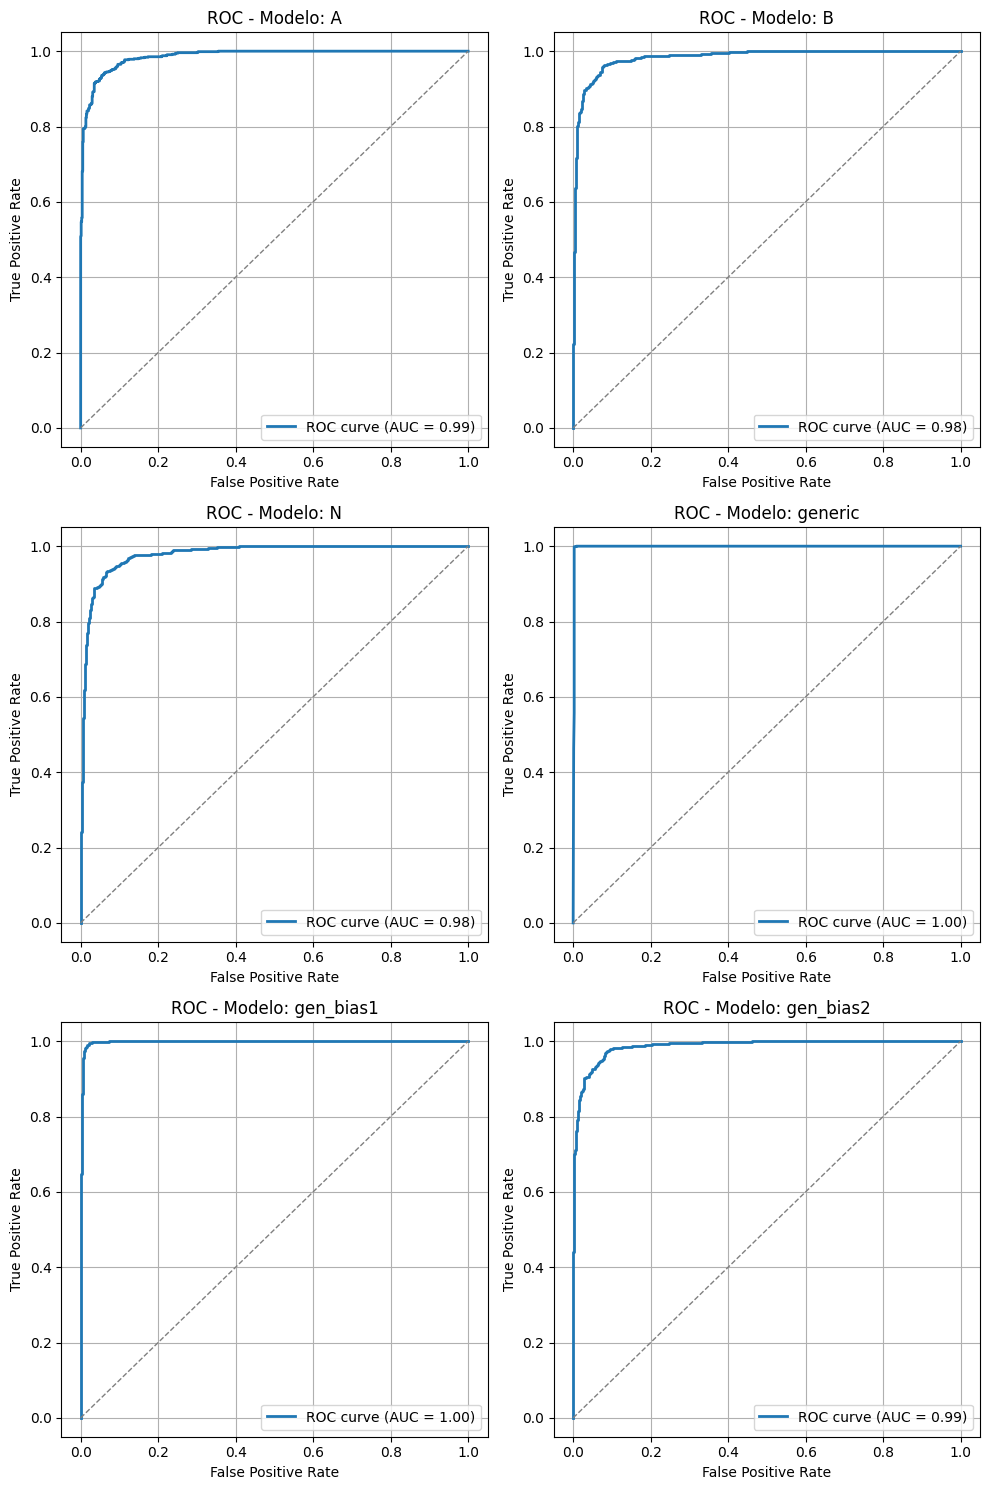

In [44]:
# Generar la curva ROC
get_all_roc_curves(gender_models, embeddings)